# Object Oriented ML

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logo.png" width=150>

In this notebook, we will learn how to properly create and use classes & functions to solve ML tasks with PyTorch. We will be following this implementation structure in subsequent notebooks.





# Overview

Here is the overview of the different classes and the functionality they will have.

*   **Vocabulary**: dictionaries to convert between raw inputs and numerical form. Usually useful for NLP tasks to build and store vocabulary dictionaries.
*   **Vectorizer**: instances of the vocabulary class for inputs and outputs and vectorizes the data for the model.
*   **Dataset**: vectorizers to process the data and data splits.
*   **Model**: PyTorch model to process inputs and return predictions.

Full credit to the code structure in the implementations below and in subsequent lessons goes to these [contributors](https://github.com/joosthub/PyTorchNLPBook/graphs/contributors).

# Set up

First we'll set up the environment, arguments, seeds for reproducability, etc.

In [1]:
# Load PyTorch library
!pip3 install torch

In [0]:
import os
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [0]:
# Set Numpy and PyTorch seeds
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
# Creating directories
def create_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [4]:
# Arguments
args = Namespace(
    seed=1234,
    cuda=True,
    shuffle=True,
    data_file="names.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="names",
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    num_epochs=20,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    batch_size=64,
    hidden_dim=300,
    dropout_p=0.1,
)

# Create save dir
create_dirs(args.save_dir)

# Expand filepaths
args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))
  

Using CUDA: True


# Data

Our task is to determine the nationality of a name given the name. Here we'll look at preprocessing the data and split it into training, validation and test splits.

In [0]:
import re
import urllib

In [0]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/surnames.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as fp:
    fp.write(html)

In [7]:
# Raw data
df = pd.read_csv(args.data_file, header=0)
df.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [8]:
# Split by nationality
by_nationality = collections.defaultdict(list)
for _, row in df.iterrows():
    by_nationality[row.nationality].append(row.to_dict())
for nationality in by_nationality:
    print ("{0}: {1}".format(nationality, len(by_nationality[nationality])))

English: 2972
French: 229
Arabic: 1603
Russian: 2373
Japanese: 775
Chinese: 220
Italian: 600
Czech: 414
Irish: 183
German: 576
Greek: 156
Spanish: 258
Polish: 120
Dutch: 236
Vietnamese: 58
Korean: 77
Portuguese: 55
Scottish: 75


In [0]:
# Create split data
final_list = []
for _, item_list in sorted(by_nationality.items()):
    if args.shuffle:
        np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_size*n)
    n_val = int(args.val_size*n)
    n_test = int(args.test_size*n)

  # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  

    # Add to final list
    final_list.extend(item_list)

In [10]:
# df with split datasets
split_df = pd.DataFrame(final_list)
split_df["split"].value_counts()

train    7680
test     1660
val      1640
Name: split, dtype: int64

In [11]:
# Preprocessing
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
split_df.surname = split_df.surname.apply(preprocess_text)
split_df.head()

,nationality,split,surname
0,Arabic,train,bishara
1,Arabic,train,nahas
2,Arabic,train,ghanem
3,Arabic,train,tannous
4,Arabic,train,mikhail


# Vocabulary

We're going to create the Vocabulary class for nationalities and surnames.

In [0]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):

        # Token to index
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}
        
        # Add unknown token
        self.add_unk = add_unk
        self.unk_token = unk_token
        if self.add_unk:
            self.unk_index = self.add_token(self.unk_token)

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx,
                'add_unk': self.add_unk, 'unk_token': self.unk_token}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        if self.add_unk:
            index = self.token_to_idx.get(token, self.unk_index)
        else:
            index =  self.token_to_idx[token]
        return index

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

In [13]:
# Vocabulary instance
nationality_vocab = Vocabulary(add_unk=False)
for index, row in df.iterrows():
    nationality_vocab.add_token(row.nationality)
print (nationality_vocab) # __str__
print (len(nationality_vocab)) # __len__
index = nationality_vocab.lookup_token("English")
print (index)
print (nationality_vocab.lookup_index(index))

<Vocabulary(size=18)>
18
0
English


# Vectorizer

In [0]:
class SurnameVectorizer(object):
    def __init__(self, surname_vocab, nationality_vocab):
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        one_hot = np.zeros(len(self.surname_vocab), dtype=np.float32)
        for token in surname:
            one_hot[self.surname_vocab.lookup_token(token)] = 1
        return one_hot

    def unvectorize(self, one_hot):
        surname = [vectorizer.surname_vocab.lookup_index(index) \
            for index in np.where(one_hot==1)[0]]
        return surname
        
    @classmethod
    def from_dataframe(cls, df):
        surname_vocab = Vocabulary(add_unk=True)
        nationality_vocab = Vocabulary(add_unk=False)

        # Create vocabularies
        for index, row in df.iterrows():
            for letter in row.surname: # char-level tokenization
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)
        return cls(surname_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab, nationality_vocab)

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}

In [15]:
# Vectorizer instance
vectorizer = SurnameVectorizer.from_dataframe(split_df)
print (vectorizer.surname_vocab)
print (vectorizer.nationality_vocab)
one_hot = vectorizer.vectorize(preprocess_text("goku"))
print (one_hot)
print (vectorizer.unvectorize(one_hot))

<Vocabulary(size=28)>
<Vocabulary(size=18)>
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
['g', 'o', 'u', 'k']


**Note**: When we vectorize our input with bagged one hot encoded format, we lose all the structure in our name. This is a major disadvantage of representing our text in bagged one-hot encoded form but we will explore more semantic structure preserving encoding methods later.

# Dataset

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class SurnameDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer

        # Data splits
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {'train': (self.train_df, self.train_size), 
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights (for imbalances)
        class_counts = df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self.vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, df):
        train_df = df[df.split=='train']
        return cls(df, SurnameVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, df, vectorizer_filepath):
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})>".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        surname_vector = self.vectorizer.vectorize(row.surname)
        nationality_index = self.vectorizer.nationality_vocab.lookup_token(row.nationality)
        return {'surname': surname_vector, 'nationality': nationality_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, shuffle=True, drop_last=False, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size, 
                                shuffle=shuffle, drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [18]:
# Dataset instance
dataset = SurnameDataset.load_dataset_and_make_vectorizer(split_df)
print (dataset) # __str__
print (dataset[5]) # __getitem__
print (dataset.class_weights)

<Dataset(split=train, size=7680)>
{'surname': array([0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'nationality': 0}
tensor([0.0006, 0.0045, 0.0024, 0.0042, 0.0003, 0.0044, 0.0017, 0.0064, 0.0055,
        0.0017, 0.0013, 0.0130, 0.0083, 0.0182, 0.0004, 0.0133, 0.0039, 0.0172])


# Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class SurnameModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p):
        super(SurnameModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in))
        z = self.dropout(z)
        y_pred = self.fc2(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

# Training

In [0]:
import torch.optim as optim

In [0]:
class Trainer(object):
    def __init__(self, dataset, model, model_state_file, save_dir, device, shuffle, 
               num_epochs, batch_size, learning_rate, early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.model = model.to(device)
        self.save_dir = save_dir
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'done_training': False,
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_state_file}
    
    def update_train_state(self):

        # Verbose
        print ("[EPOCH]: {0} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
          self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1], 
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1]))

        # Save one model at least
        if self.train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), self.train_state['model_filename'])
            self.train_state['stop_early'] = False

        # Save model if performance improved
        elif self.train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = self.train_state['val_loss'][-2:]

            # If loss worsened
            if loss_t >= self.train_state['early_stopping_best_val']:
                # Update step
                self.train_state['early_stopping_step'] += 1

            # Loss decreased
            else:
                # Save the best model
                if loss_t < self.train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), self.train_state['model_filename'])

                # Reset early stopping step
                self.train_state['early_stopping_step'] = 0

            # Stop early ?
            self.train_state['stop_early'] = self.train_state['early_stopping_step'] \
              >= self.train_state['early_stopping_criteria']
        return self.train_state
  
    def compute_accuracy(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        n_correct = torch.eq(y_pred_indices, y_target).sum().item()
        return n_correct / len(y_pred_indices) * 100
  
    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # Iterate over train dataset

            # initialize batch generator, set loss and acc to 0, set train mode on
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, 
                device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # zero the gradients
                self.optimizer.zero_grad()

                # compute the output
                y_pred = self.model(batch_dict['surname'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['nationality'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute gradients using loss
                loss.backward()

                # use optimizer to take a gradient step
                self.optimizer.step()
                
                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['nationality'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # initialize batch generator, set loss and acc to 0; set eval mode on
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred =  self.model(batch_dict['surname'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['nationality'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['nationality'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = self.update_train_state()
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        # initialize batch generator, set loss and acc to 0; set eval mode on
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
            batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  self.model(batch_dict['surname'])

            # compute the loss
            loss = self.loss_func(y_pred, batch_dict['nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = self.compute_accuracy(y_pred, batch_dict['nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
    
    def plot_performance(self):
        # Figure size
        plt.figure(figsize=(15,5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(trainer.train_state["train_loss"], label="train")
        plt.plot(trainer.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(trainer.train_state["train_acc"], label="train")
        plt.plot(trainer.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
        plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # Show plots
        plt.show()
    
    def save_train_state(self):
        self.train_state["done_training"] = True
        with open(os.path.join(self.save_dir, "train_state.json"), "w") as fp:
            json.dump(self.train_state, fp)

In [23]:
# Initialization
dataset = SurnameDataset.load_dataset_and_make_vectorizer(split_df)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = SurnameModel(input_dim=len(vectorizer.surname_vocab), 
                     hidden_dim=args.hidden_dim, 
                     output_dim=len(vectorizer.nationality_vocab),
                     dropout_p=args.dropout_p)
print (model.named_modules)

<bound method Module.named_modules of SurnameModel(
  (fc1): Linear(in_features=28, out_features=300, bias=True)
  (dropout): Dropout(p=0.1)
  (fc2): Linear(in_features=300, out_features=18, bias=True)
)>


In [24]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 0 | [LR]: 0.001 | [TRAIN LOSS]: 2.73 | [TRAIN ACC]: 29.0% | [VAL LOSS]: 2.53 | [VAL ACC]: 39.6%
[EPOCH]: 1 | [LR]: 0.001 | [TRAIN LOSS]: 2.34 | [TRAIN ACC]: 38.8% | [VAL LOSS]: 2.26 | [VAL ACC]: 36.4%
[EPOCH]: 2 | [LR]: 0.001 | [TRAIN LOSS]: 2.11 | [TRAIN ACC]: 38.3% | [VAL LOSS]: 2.13 | [VAL ACC]: 34.8%
[EPOCH]: 3 | [LR]: 0.001 | [TRAIN LOSS]: 1.99 | [TRAIN ACC]: 38.9% | [VAL LOSS]: 2.08 | [VAL ACC]: 38.2%
[EPOCH]: 4 | [LR]: 0.001 | [TRAIN LOSS]: 1.92 | [TRAIN ACC]: 38.6% | [VAL LOSS]: 2.03 | [VAL ACC]: 36.9%
[EPOCH]: 5 | [LR]: 0.001 | [TRAIN LOSS]: 1.87 | [TRAIN ACC]: 39.6% | [VAL LOSS]: 2.00 | [VAL ACC]: 35.8%
[EPOCH]: 6 | [LR]: 0.001 | [TRAIN LOSS]: 1.83 | [TRAIN ACC]: 39.9% | [VAL LOSS]: 1.96 | [VAL ACC]: 38.4%
[EPOCH]: 7 | [LR]: 0.001 | [TRAIN LOSS]: 1.79 | [TRAIN ACC]: 40.3% | [VAL LOSS]: 1.94 | [VAL ACC]: 38.9%
[EPOCH]: 8 | [LR]: 0.001 | [TRAIN LOSS]: 1.76 | [TRAIN ACC]: 40.9% | [VAL LOSS]: 1.94 | [VAL ACC]: 38.9%
[EPOCH]: 9 | [LR]: 0.001 | [TRAIN LOSS]: 1.73 | [TRAIN 

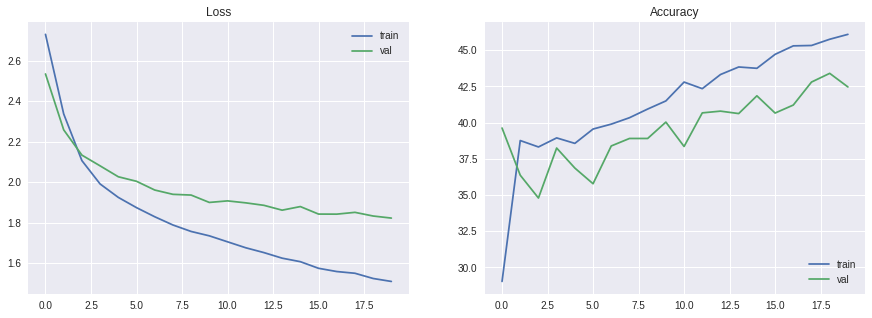

In [25]:
# Plot performance
trainer.plot_performance()

In [26]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 1.91
Test Accuracy: 43.0%


In [0]:
# Save all results
trainer.save_train_state()

# Inference

In [0]:
class Inference(object):
    def __init__(self, model, vectorizer, device="cpu"):
        self.model = model.to(device)
        self.vectorizer = vectorizer
        self.device = device
  
    def predict_nationality(self, dataset):
        # Batch generator
        batch_generator = dataset.generate_batches(
            batch_size=len(dataset), shuffle=False, device=self.device)
        self.model.eval()
        
        # Predict
        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  self.model(batch_dict['surname'], apply_softmax=True)

            # Top k nationalities
            y_prob, indices = torch.topk(y_pred, k=len(self.vectorizer.nationality_vocab))
            probabilities = y_prob.detach().to('cpu').numpy()[0]
            indices = indices.detach().to('cpu').numpy()[0]

            results = []
            for probability, index in zip(probabilities, indices):
                nationality = self.vectorizer.nationality_vocab.lookup_index(index)
                results.append({'nationality': nationality, 'probability': probability})

        return results

In [0]:
# Load vectorizer
with open(args.vectorizer_file) as fp:
    vectorizer = SurnameVectorizer.from_serializable(json.load(fp))

In [30]:
# Load the model
model = SurnameModel(input_dim=len(vectorizer.surname_vocab), 
                     hidden_dim=args.hidden_dim, 
                     output_dim=len(vectorizer.nationality_vocab),
                     dropout_p=args.dropout_p)
model.load_state_dict(torch.load(args.model_state_file))
print (model.named_modules)

<bound method Module.named_modules of SurnameModel(
  (fc1): Linear(in_features=28, out_features=300, bias=True)
  (dropout): Dropout(p=0.1)
  (fc2): Linear(in_features=300, out_features=18, bias=True)
)>


In [0]:
# Initialize
inference = Inference(model=model, vectorizer=vectorizer, device=args.device)

In [0]:
class InferenceDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer
        self.target_size = len(self.df)

    def __str__(self):
        return "<Dataset(size={1})>".format(self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.df.iloc[index]
        surname_vector = self.vectorizer.vectorize(row.surname)
        return {'surname': surname_vector}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, shuffle=True, drop_last=False, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size, 
                                shuffle=shuffle, drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [37]:
# Inference
surname = input("Enter a surname to classify: ")
infer_df = pd.DataFrame([surname], columns=['surname'])
infer_df.surname = infer_df.surname.apply(preprocess_text)
infer_dataset = InferenceDataset(infer_df, vectorizer)
results = inference.predict_nationality(dataset=infer_dataset)
results

Enter a surname to classify: Goku


[{'nationality': 'Korean', 'probability': 0.44534385},
 {'nationality': 'Chinese', 'probability': 0.1730141},
 {'nationality': 'Japanese', 'probability': 0.14254414},
 {'nationality': 'Vietnamese', 'probability': 0.1355816},
 {'nationality': 'Arabic', 'probability': 0.04341898},
 {'nationality': 'Czech', 'probability': 0.013530745},
 {'nationality': 'Polish', 'probability': 0.010098705},
 {'nationality': 'Scottish', 'probability': 0.009004401},
 {'nationality': 'German', 'probability': 0.0053680516},
 {'nationality': 'English', 'probability': 0.005214144},
 {'nationality': 'Dutch', 'probability': 0.0051329494},
 {'nationality': 'Russian', 'probability': 0.005057049},
 {'nationality': 'French', 'probability': 0.0021749474},
 {'nationality': 'Greek', 'probability': 0.0019787527},
 {'nationality': 'Irish', 'probability': 0.0013620977},
 {'nationality': 'Spanish', 'probability': 0.00057842134},
 {'nationality': 'Portuguese', 'probability': 0.00030085415},
 {'nationality': 'Italian', 'proba

# TODO

- tqdm notebook